# 维数约简

为什么要约简维数？

当数据集包含大量特征，有的特征包含大量预测信息，有的仅包含少量信息或纯粹是噪音，很多特征之间也可能高度相关。维数约简的目的在于剔除噪音，只保留有意义的特征，这不仅使数据集更容易管理和理解，预测模型的准确性也会相应提高。

常用方法有哪些？

1. 相关系数矩阵
2. 主成分分析
3. 随机PCA
4. 因子分析
5. 线性判别分析
6. 核PCA

## 1. 相关系数矩阵

相关系数：度量数值变量同向/反向运动的关联程度，取值范围$[-1, 1]$，1表示完全正相关，-1表示完全负相关，0表示线性无关。

Python实现：pd.corr(), np.corrcoef()用于计算相关系数矩阵，sns.heatmap()创建热力图可视化。

解读：如果两个特征高度相关，可以保留其中一个，尽可能保留相互独立的变量。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("ggplot")

使用iris数据集。

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


计算相关系数矩阵。

In [3]:
cor_matrix = iris_df.corr()
np.round(cor_matrix, 2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.00,-0.12,0.87,0.82
sepal width (cm),-0.12,1.00,-0.43,-0.37
petal length (cm),0.87,-0.43,1.00,0.96
petal width (cm),0.82,-0.37,0.96,1.00


创建热力图，可视化相关系数矩阵。

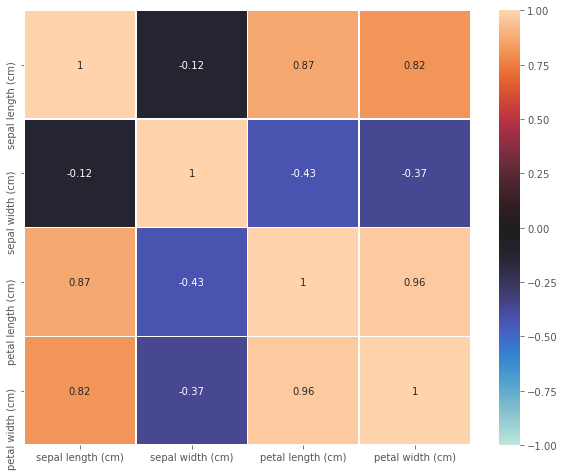

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(
    cor_matrix,
    annot=True,  # 将数值添加到单元格
    vmin=-1,  # 根据数值范围调整颜色区间
    vmax=1, 
    center=0,
    linewidths=0.5,  # 控制单元格之间的间隙
    #mask=np.abs(cor_matrix) < 0.6,  # 仅显示相关系数大于0.6的单元格
    ax=ax
)

热力图显示，sepal length和petal length，petal width高度正相关，petal length和petal width高度相关。所以，可以考虑剔除petal length和petal width两个特征。

这个简单的例子仅用于说明如何用相关系数矩阵约简维数，考虑到原始数据只有4个特征，完全没有必要约简维数。

## 2. 主成分分析

主成分分析（PCA）是最常用的降维技术之一，它把大量相关变量转化为几组无关变量，这些无关变量称为“主成分”。

sklearn提供接口PCA类实现主成分分析。

拟合PCA模型前要先选择约简维数，即主成分个数，有两种常用方法：1. 参考相关文献的研究成果；2. 从相关系数矩阵获得启发。

In [5]:
from sklearn.decomposition import PCA

# 选择主成分个数，这里选择2
pca = PCA(n_components=2)
res = pca.fit_transform(iris_df)

print("original shape: ", iris_df.shape)
print("transformed shape: ", res.shape)

original shape:  (150, 4)
transformed shape:  (150, 2)


调用pca.fit_transform得到一个n维数组，每一列代表一个“主成分”，它们是原始特征的线性组合。

第一个主成分对原始数据的变异（方差）解释最大，第二个主成分与第一个主成分正交（无相关关系），它包含了剩余变异的大部分，第三个主成分与前两个主成分正交，并包含剩余变异的大部分，以此类推。

In [6]:
res[:5, :]

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451]])

用散点图查看主成分的关系，它们是线性无关的。

Text(0, 0.5, 'Second Main Component')

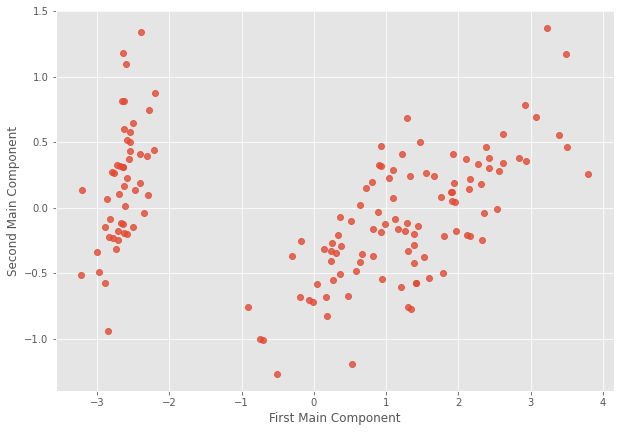

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.regplot(x=res[:, 0], y=res[:, 1], scatter=True, fit_reg=False, ax=ax)
ax.set_xlabel("First Main Component")
ax.set_ylabel("Second Main Component")

explained_variance_ratio_包含了所有主成分对原始数据方差的解释比率。降维不可避免地损失了原始数据的部分信息，降维的同时要尽可能多地保留信息。

In [8]:
var_ratio = pca.explained_variance_ratio_

for idx, val in enumerate(var_ratio, 1):
    print("principle component %d: %.2f%%" % (idx, val * 100))
print("total: %.2f%%" % np.sum(var_ratio * 100))

principle component 1: 92.46%
principle component 2: 5.31%
total: 97.77%


主成分个数等于2，就保留了原始数据集约98%的变异。

除了根据经验或相关系数矩阵外，可以用数据挖掘的方法选择主成分个数。拟合PCA模型时令主成分个数等于原始特征的数目，然后查看主成分的累积解释方差比率，选择令人满意的临界点对应的主成分个数。

principle component 1: 92.46%
principle component 2: 5.31%
principle component 3: 1.71%
principle component 4: 0.52%
total: 100.00%


Text(0, 0.5, 'Explained Variance Ratio(%)')

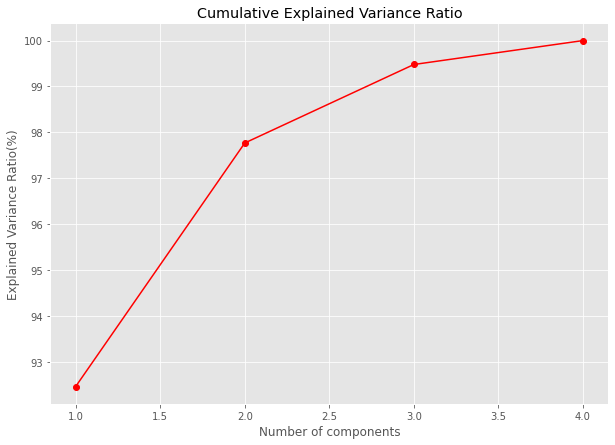

In [9]:
# n_components=None, 主成分个数等于原始特征的数量
pca2 = PCA(n_components=None)
pca2.fit(iris_df)
evr = pca2.explained_variance_ratio_ * 100

for idx, val in enumerate(evr, 1):
    print("principle component %d: %.2f%%" % (idx, val))
print("total: %.2f%%" % np.sum(evr))

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.arange(1, len(evr) + 1), np.cumsum(evr), "r-o")
ax.set_title("Cumulative Explained Variance Ratio")
ax.set_xlabel("Number of components")
ax.set_ylabel("Explained Variance Ratio(%)")

也可以先选择最低的累计解释方差比率，让模型自动选择最优的主成分个数。

In [10]:
target = 0.95  # 最低累计解释方差比率
res = PCA(n_components=target).fit_transform(iris_df)
res[:5, :]

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451]])

## 3. 随机PCA

PCA类默认使用奇异值分解算法(SVD)，处理大数据时速度很慢，Randomized PCA采取基于随机SVD的算法，计算速度非常快，结果与经典SVD差异不大，特别适用于大型数据集。

先创建一个虚拟大型数据集，然后分别使用经典SVD和随机SVD算法，对比计算时间和最终结果。

In [11]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

X, y = make_classification(
    n_samples=10000,  # 10000个观测值
    n_features=1000,  # 1000个特征
    n_informative=100,  # 100个有预测作用的特征
    n_redundant=900,  # 900个冗余的特征
    n_classes=2,  # 目标变量有两个类别
    random_state=123
)

评估经典SVD算法需要的时间。

In [12]:
%%time

pca_svd = PCA(n_components=50, svd_solver="full")
res_svd = pca_svd.fit_transform(X)

CPU times: user 3.26 s, sys: 63.1 ms, total: 3.33 s
Wall time: 665 ms


评估随机SVD算法需要的时间。

In [13]:
%%time

pca_rsvd = PCA(n_components=50, svd_solver="randomized", random_state=123)
res_rsvd = pca_rsvd.fit_transform(X)

CPU times: user 1.36 s, sys: 97.9 ms, total: 1.46 s
Wall time: 316 ms


对比主成分和累计解释方差比率。

In [14]:
print(res_svd[:5, :5])
print(np.sum(pca_svd.explained_variance_ratio_))

[[ -35.31540007  -39.98628806 -274.32980501  -27.4946712    77.54435473]
 [-107.77935017   37.53502538 -159.77096307  131.49349957   25.25804827]
 [ 108.37551655  -15.40239858  -62.96425787 -132.79963657  -63.94973487]
 [-105.79569613  358.60693594   24.7166602   -17.55204505  134.10581326]
 [-117.80092422   56.90329203 -333.89478323 -105.58694003 -203.47273697]]
0.7461276067240424


In [15]:
print(res_rsvd[:5, :5])
print(np.sum(pca_rsvd.explained_variance_ratio_))

[[ -35.31811083  -39.98782647 -274.3356045   -27.49536884   77.58832675]
 [-107.77688031   37.53173418 -159.76762465  131.50093451   25.2763213 ]
 [ 108.37756582  -15.40584496  -62.95926132 -132.81009813  -63.95606976]
 [-105.79345418  358.60456052   24.71247005  -17.5314516   134.07833206]
 [-117.80396459   56.90223403 -333.90297705 -105.57181181 -203.4748604 ]]
0.7456404795597943


结果对比显示，随机SVD算法耗费的时间显著低于SVD，主成分和累计解释方差比率的差异非常小。

## 4. 因子分析

因子分析(Factor Analysis)：假设原始特征同时受到"潜在变量"的影响，因子分析旨在提权潜在因子。

PCA和FA的区别是什么？

两种方法都用于降维，但它们的核心原理是不同的。PCA根据原始特征集创建主成分，每一个主成分都是特征的线性组合，FA旨在从原始特征中挖掘潜在因子，这些潜在因子同时影响多个特征并导致变量相关。

如下图所示，左边的图表描述了PCA的原理，右边的图表描述了FA的原理。

![pca_vs_fa](./pictures/PCA_vs_FA.png)

也可以用数学公式简单描述两种方法的降维原理，假设有4个特征：$X_1, X_2, X_3, X_4$

用PCA创建两个主成分：

$$C_1 = a_1*X_1 + a_2*X_2 + a_3*X_3 + a_4*X_4$$
$$C_2 = b_1*X_1 + b_2*X_2 + b_3*X_3 + b_4*X_4$$

$C_1, C_2$是主成分，$a_i, b_i$是加权因子，主成分是所有特征的线性组合。

用FA提取两个潜在因子：

$$X_1 = \alpha_1 * F_1 + \beta_1 * F_2 + \epsilon_1$$
$$X_2 = \alpha_2 * F_1 + \beta_2 * F_2 + \epsilon_2$$
$$X_3 = \alpha_3 * F_1 + \beta_3 * F_2 + \epsilon_3$$
$$X_4 = \alpha_4 * F_1 + \beta_4 * F_2 + \epsilon_4$$

$F_1, F_2$是潜在因子，$\alpha_i, \beta_i$是加权因子，$\epsilon_i$代表没有被潜在因子解释的其它因素，理解为随机冲击。

假设iris有两个潜在因子，采用因子分析降维。

Sklearn提供FactorAnalysis类实现，建模步骤与PCA非常相似，先选择潜在因子的数量，拟合模型并旋转，最后输出结果。

In [16]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=2)
fa_res = fa.fit_transform(iris_df)

print(fa_res[:5, :])
print(fa_res.shape)

[[-1.32761727 -0.56131076]
 [-1.33763854 -0.00279765]
 [-1.40281483  0.30634949]
 [-1.30104274  0.71882683]
 [-1.33342439 -0.36458899]]
(150, 2)


PCA和FA的建模步骤如此相似，又都用于降维，那么在处理实际问题时应该如何选择？

答案取决于研究目的，经验之谈：

* 如果目的纯粹是降低数据集的维度，使用PCA。
* 如果有先验理论指出观测变量背后有潜在因素，希望检验类似的模型，使用因子分析。

## 5. 线性判别分析

线性判别分析(Linear Discriminant Analysis, LDA): 分类模型，也可用于维数约简。与PCA不同，LDA降维要求分类目标变量作为输入，属于有监督机器学习算法。

PCA试图最大化原始数据的方差，LDA不仅保留原始数据的方差，还最大化不同类别之间的差异，在建模过程中需要用到目标变量。**LDA只能用于分类问题**。

关于PCA和LDA的差异：

* [对比PCA和LDA](https://medium.com/analytics-vidhya/pca-vs-lda-vs-t-sne-lets-understand-the-difference-between-them-22fa6b9be9d0)
* [如何用PCA和LDA实现降维](https://medium.com/machine-learning-researcher/dimensionality-reduction-pca-and-lda-6be91734f567)

iris数据集有四个特征和一个目标变量，分别表示3个种类，用sklearn实现LDA降维，过程与PCA类似。

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# 与PCA类似，先指定主成分的个数
lda = LDA(n_components=2)
lda_res = lda.fit_transform(iris.data, iris.target)

print(lda_res[:5, :])
print(lda_res.shape)
print(np.sum(lda.explained_variance_ratio_))

[[ 8.06179978  0.30042062]
 [ 7.12868772 -0.78666043]
 [ 7.48982797 -0.26538449]
 [ 6.81320057 -0.67063107]
 [ 8.13230933  0.51446253]]
(150, 2)
0.9999999999999999


创建散点图，查看第一主成分和第二主成分的关系，按照目标变量类别分组。

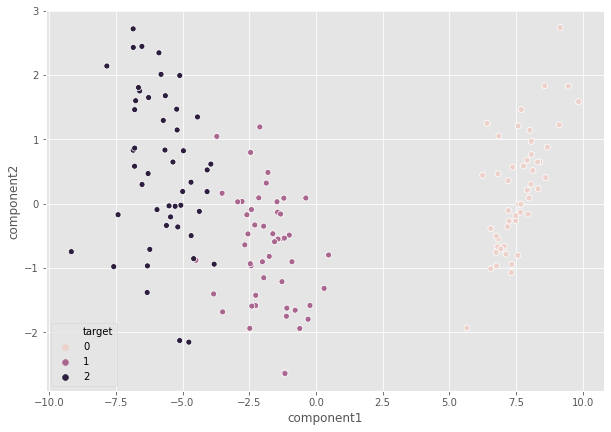

In [18]:
lda_res_df = pd.DataFrame(lda_res, columns=["component1", "component2"])
lda_res_df["target"] = iris.target

fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=lda_res_df, x="component1", y="component2", hue="target", ax=ax)

## 6. 核PCA

大多数机器学习算法只能用于处理线性关系的数据集，例如上面介绍的PCA，当数据具有非线性关系的时候，需要使用特殊的算法。

如下图所示，左边的子图显示线性可分的数据，用PCA可以实现降维，但右边的子图显示线性不可分的数据，这时候需要用到核PCA。

![non_linear_data](../pic/non_linear_data.png)

处理线性不可分数据的核心思想：将数据映射到一个更高维的空间，使其变为线性可分，这种映射就是通过所谓的"核函数"完成。

关于核函数的更多细节，参考：[如何用核PCA实现非线性降维](https://sebastianraschka.com/Articles/2014_kernel_pca.html)

接下来用案例说明如何用Sklearn实现核PCA。

创建非线性数据集，一个外圆包含一个内圆。

Text(0, 0.5, 'feature 2')

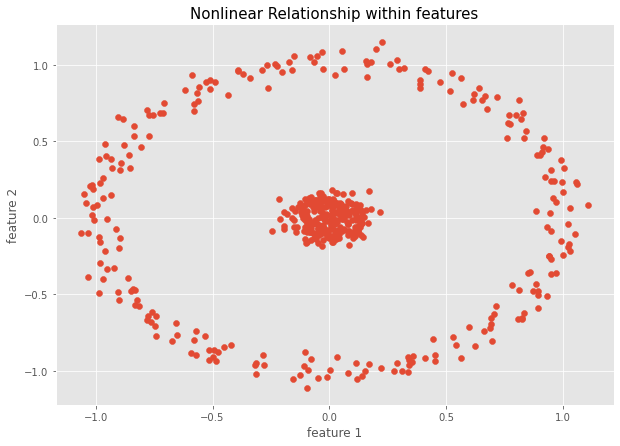

In [19]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=500, random_state=123, factor=0.1, noise=0.05)

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(X[:, 0], X[:, 1])
ax.set_title("Nonlinear Relationship within features", fontsize=15)
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")

先用经典PCA实现降维，主成分个数等于2，拟合模型后发现第一主成分和第二主成分仍然是非线性的。结果符合预期，经典PCA的确无法处理线性不可分的数据。

Text(0, 0.5, 'Second Component')

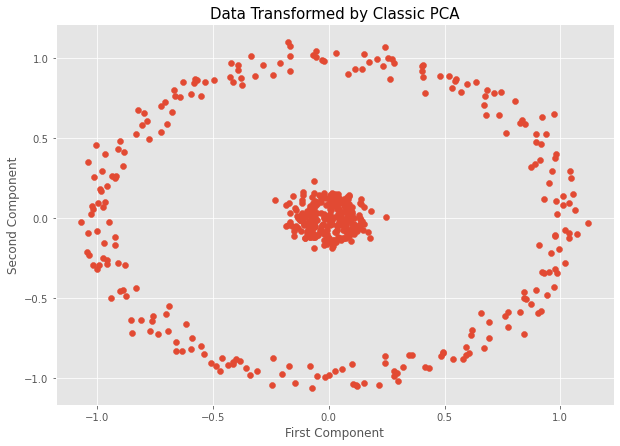

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
res_pca = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(res_pca[:, 0], res_pca[:, 1])
ax.set_title("Data Transformed by Classic PCA", fontsize=15)
ax.set_xlabel("First Component")
ax.set_ylabel("Second Component")

Sklearn提供接口类KernelPCA来处理线性不可分的数据。

构造KernelPCA实例有3个核心参数：

* n_components: 主成分个数
* kernel: 核函数，将原始数据投射到更高维的空间(通过对原始特征进行非线性组合)从而令数据变为线性可分，可选值包括'linear','poly','rbf'等
* gamma: 核函数的参数，一个待优化的参数

在处理现实问题的时候，可以尝试用网格搜索(GridSearch)的优化技术寻找最优的核函数以及gamma值。

Text(0, 0.5, 'Second Component')

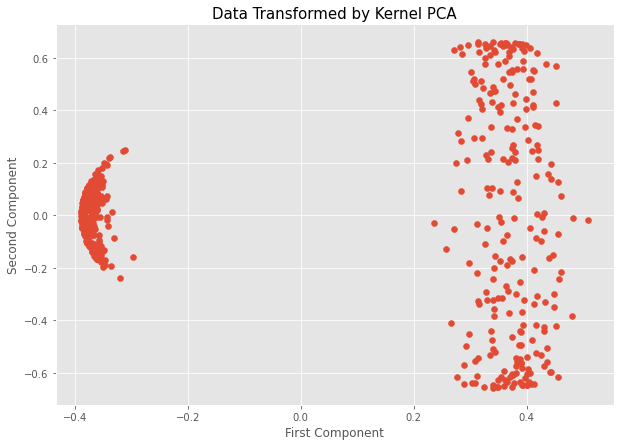

In [26]:
from sklearn.decomposition import KernelPCA

# kernel='rbf'，径向基函数，gamma=1，这样的组合得到令人满意的结果
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=1)
res_kpca = kpca.fit_transform(X)

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(res_kpca[:, 0], res_kpca[:, 1])
ax.set_title("Data Transformed by Kernel PCA", fontsize=15)
ax.set_xlabel("First Component")
ax.set_ylabel("Second Component")